## Load and Create Dataset

In [ ]:
pip install google-cloud-bigquery

In [1]:
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:


# Setup Google Cloud BigQuery API

# Replace with your own key path
key_path = "/Users/theodoreleeiv/Documents/Documents - Theodore’s MacBook Pro/Google Cloud/inbound-density-428819-p8-aef577a5f38e.json"
credentials = service_account.Credentials.from_service_account_file(key_path)

client = bigquery.Client()


def QUERY(query):
    """
    Queries BigQuery
    :param query: string
    :return: dataframe
    """
    query = str(query)
    query_job = client.query(query)
    return query_job.result().to_dataframe()

In [3]:

df = QUERY("""
  SELECT
    r.subject_id,
    r.stay_id,
    r.hadm_id,
    r.readmit_stay_id,
    edadmitdate,
    eddischargedate,
    EXTRACT(DAYOFWEEK FROM eddischargedate) AS discharge_dow,
    EXTRACT(MONTH FROM eddischargedate) AS discharge_month,
    edadmithour,
    eddischargehour,
    LOS_hr,
    arrival_transport,
    disposition,
    gender,
    anchor_age,
    insurance,
    marital_status,
    language,
    race_group,
    temperature,
    heartrate,
    resprate,
    o2sat,
    sbp,
    dbp,
    acuity,
    m.name AS med_name,
    icd_title,
    mental_health_category,
    is_readmission
  

FROM
  `inbound-density-428819-p8.patient_info.MH-ED-READMISSIONS` AS r

LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-PATIENT-DEMO` AS p

ON r.subject_id = p.subject_id

LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-ED-DIAGNOSIS` AS d
ON
  r.stay_id = d.stay_id
  
LEFT JOIN
    `physionet-data.mimiciv_ed.triage` AS t
ON 
    r.stay_id = t.stay_id
LEFT JOIN 
    `physionet-data.mimiciv_ed.medrecon` AS m
ON  
    r.stay_id = m.stay_id
  
WHERE d.is_mh_disorder = 1
""")

In [4]:
# Calculate the number of comorbities per patient per visit

comorbities = QUERY("""
  SELECT
    subject_id,
    stay_id,
    SUM(num_comorbities) AS num_comorbitites
    FROM
    (SELECT
      d.subject_id,
      d.stay_id,
      CASE
        WHEN seq_num > 1 THEN 1
        ELSE 0
      END AS num_comorbities
    FROM
      `inbound-density-428819-p8.patient_info.MH-ED-DIAGNOSIS` AS d

    WHERE d.is_mh_disorder = 1
    ORDER BY
      num_comorbities DESC) AS patient_counts
GROUP BY
  subject_id,stay_id

""")

In [5]:
# merge the number of comorbitites with the main dataframe on subject_id and stay_id
df = df.merge(comorbities,how='left',on=['subject_id','stay_id'])

### Drop Duplicates

In [6]:
# Drop any duplicates if there are any in the data
df.drop_duplicates(inplace=True)

### Split the Data into training and test sets

In [8]:
from sklearn.model_selection import train_test_split
train_df,test_df = train_test_split(df,test_size=0.25,random_state=42,stratify=df['is_readmission'])

In [9]:
train_df.head()

,subject_id,stay_id,hadm_id,readmit_stay_id,edadmitdate,eddischargedate,discharge_dow,discharge_month,edadmithour,eddischargehour,...,resprate,o2sat,sbp,dbp,acuity,med_name,icd_title,mental_health_category,is_readmission,num_comorbitites
244884,11619714,39064043,22688963,<NA>,2135-07-21,2135-07-23,7,7,22,13,...,14.000000000,98.000000000,126.000000000,68.000000000,2.000000000,Zocor,UNSPECIFIED INTELLECTUAL DISABILITIES,Intellectual Disabilities,0,1
159530,11582633,39974345,29673233,<NA>,2139-06-01,2139-06-01,2,6,10,11,...,18.000000000,99.000000000,175.000000000,95.000000000,2.000000000,Diovan,DEPRESSIVE DISORDER,Mood Disorders,0,1
432594,18498275,33668191,<NA>,<NA>,2196-02-06,2196-02-06,7,2,18,21,...,18.000000000,99.000000000,140.000000000,77.000000000,3.000000000,None,ALCOHOL ABUSE-UNSPEC,Substance-Related Mental Disorders,0,1
278462,14111050,30240812,29819053,30240812,2199-02-13,2199-02-14,5,2,21,11,...,18.000000000,100.000000000,134.000000000,63.000000000,3.000000000,sennosides [senna],"Major depressive disorder, single episode, uns...",Mood Disorders,1,0
114915,17482272,34672070,22023530,<NA>,2178-11-24,2178-11-24,3,11,12,15,...,18.000000000,96.000000000,98.000000000,48.000000000,2.000000000,metformin,DEPRESSIVE DISORDER,Mood Disorders,0,0


In [10]:
train_df.shape

(205143, 31)

### Check for NaNs

In [11]:
train_df.isnull().sum()

subject_id                     0
stay_id                        0
hadm_id                    63805
readmit_stay_id           142115
edadmitdate                    0
eddischargedate                0
discharge_dow                  0
discharge_month                0
edadmithour                    0
eddischargehour                0
LOS_hr                         0
arrival_transport              0
disposition                    0
gender                         0
anchor_age                     8
insurance                  21531
marital_status             12721
language                   10260
race_group                     0
temperature                 7761
heartrate                   4936
resprate                    6999
o2sat                       6421
sbp                         5272
dbp                         5852
acuity                      1098
med_name                   23299
icd_title                      0
mental_health_category         0
is_readmission                 0
num_comorb

There is quite of bit of NaNs in the data. However, some NaNs are expected in hadm_id, not all patients have an associated hadm_id or readmit_stay_id, days_to_readmission, med_name (medication name).

### Clean and Transform Columns

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 205143 entries, 244884 to 216150
Data columns (total 31 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   subject_id              205143 non-null  Int64 
 1   stay_id                 205143 non-null  Int64 
 2   hadm_id                 141338 non-null  Int64 
 3   readmit_stay_id         63028 non-null   Int64 
 4   edadmitdate             205143 non-null  dbdate
 5   eddischargedate         205143 non-null  dbdate
 6   discharge_dow           205143 non-null  Int64 
 7   discharge_month         205143 non-null  Int64 
 8   edadmithour             205143 non-null  Int64 
 9   eddischargehour         205143 non-null  Int64 
 10  LOS_hr                  205143 non-null  Int64 
 11  arrival_transport       205143 non-null  object
 12  disposition             205143 non-null  object
 13  gender                  205143 non-null  object
 14  anchor_age              205135 non-n

In [14]:
# set the index to stay_id
train_df.set_index('stay_id',inplace=True)


Cleaning/Transformation Tasks
- Convert gender column to numeric binary
- Change the dtype of temperature, heartrate, reprate,o2sat, sbp, dbp, pain, and acuity to float values
- Unmarried individuals, feature engineer a binary variable, married vs unmarried
- Black/African Patiants, feature engineer a binary variable, Black/African?
- PORTUGUESE Patiants, feature engineer a binary variable, PORTUGUESE?
- Cuban Patiants, feature engineer a binary variable, Cuban?
- BLACK/AFRICAN AMERICAN patiants, feature engineer a binary variable, BLACK/AFRICAN AMERICAN?
- Puerto Rican Patiants, feature engineer a binary variable, Puerto Rican?
- Unknown Patiants, feature engineer a binary variable, Unknown?
- Hispanic or Latino Patiants, feature engineer a binary variable, Hispanic or Latino?
- Honduran Patiants, feature engineer a binary variable, Honduran?
- Patients 50 - 59
- Patients 40 - 49
- Num of Comorbitites
- Various medications (Create medication frequiences accounting for medications not listed by setting the default to 0) -> compute frequencies on the training set to prevent data leakage

In [15]:
# Create a customtransofrmer for each column transformation for the pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Change gender column to a binary

class GenderMapper(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.gender_map = {'F': 0, 'M': 1}  

    def fit(self, X, y=None):
        return self  

    def transform(self, X):
        X_copy = X.copy()
        # Apply the gender mapping to the gender column
        if 'gender' in X_copy.columns:
            X_copy['gender'] = X_copy['gender'].map(self.gender_map)
        return X_copy

In [16]:
# change the dtype of temperature, heartrate, reprate,o2sat, sbp, dbp, and acuity to float values
class ConvertVitalSignsToFloats(BaseEstimator, TransformerMixin):
    """
    Converts Vital Signs to Floats
    """
    def __init__(self):
        self.type = float
    def fit(self, X, y=None):
        return self  
    def transform(self, X):
        X_copy = X.copy()
        
        vital_cols = ['temperature','heartrate','resprate','o2sat','sbp','dbp','acuity']
        
        for col in vital_cols:
            if col in X_copy.columns:
                try:
                    X_copy[col] =  X_copy[col].astype(float)
                except ValueError as e:
                    print(f"[Error] Could not convert column '{col}' to float. Error: {e} converting to NaN")
                    X_copy[col] = pd.to_numeric(X_copy[col], errors='coerce')
                    
            else:
                print(f'Not Column {col} not found in list')
        return X_copy
    
class CelsiusToFahrenheit(BaseEstimator, TransformerMixin):
    """
    Converts temperature signs recorded in celsisus to fahrenheit
    """
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self  
    def transform(self, X):
        X_copy = X.copy()
        
        if 'temperature' in X_copy.columns:
            try:
                 # Create a mask for likely Celsius values
                mask = X_copy['temperature'] <= 38
                X_copy.loc[mask, 'temperature'] = X_copy.loc[mask, 'temperature'] * 9/5 + 32
            except ValueError as e:
                print(f"[Error] Could not convert column. Error: {e}")
        return X_copy
    

In [17]:
# Create an unmarried vs married column from marital status column
class MaritalStatusMapper(BaseEstimator, TransformerMixin):
    """
    Converts marital status to a binary variable, married/partnered vs single/ not partnered
    """
    def __init__(self):
        self.is_married_map = {'None':1,'MARRIED':1,'WIDOWED':0,'DIVORCED':0,'SINGLE':0}

    def fit(self, X, y=None):
        return self  

    def transform(self, X):
        X_copy = X.copy()
        # Apply the gender mapping to the gender column
        if 'marital_status' in X_copy.columns:
            X_copy['marital_status'] = X_copy['marital_status'].map(self.is_married_map)
        return X_copy


In [18]:
class GetTotalAdmissionsAndDischarges(BaseEstimator, TransformerMixin):
    """
    Calculates total admissions and discharges per admission day and discharge day, respectively
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self  

    def transform(self, X):
        X_copy = X.copy().reset_index()
        
        # calculate the total admissions and total discharges 
        total_admissions = X_copy.groupby(by='edadmitdate')['stay_id'].count().reset_index().rename(columns={'stay_id':'total_admissions'})
        total_discharges = X_copy.groupby(by='eddischargedate')['stay_id'].count().reset_index().rename(columns={'stay_id':'total_discharges'})
        
        # merge these with original dataframe
        X_copy = X_copy.merge(total_admissions,how='left',on=['edadmitdate'])
        X_copy = X_copy.merge(total_discharges,how='left',on=['eddischargedate'])
        X_copy.drop(['edadmitdate','eddischargedate'],axis=1,inplace=True)
        X_copy.set_index('stay_id', inplace=True)
        return X_copy


In [19]:
from collections import defaultdict

class GetMedicationFrequencies(BaseEstimator, TransformerMixin):
    """
    Encode medications using their frequency
    """
    def __init__(self):
        self.med_to_freq = None
        self.freq_to_meds = None

    def fit(self, X, y=None):
        # Learn med freqencies
        freqs =  X['med_name'].value_counts().to_dict()
        
        # Mapping: med_names → frequency
        self.med_to_freq = defaultdict(lambda: 0, freqs)
        
        # Mapping: frequency → set of med_names
        self.freq_to_meds = defaultdict(set)
        for med, freq in freqs.items():
            self.freq_to_meds[freq].add(med)

        return self  

    def transform(self, X):
        X_copy = X.copy()
        # Replace meds with their frequency
        X_copy['med_name'] =  X_copy['med_name'].map(self.med_to_freq)
        
        # Rename the med column name
        X_copy.rename(columns={'med_name':'med_freq_id'},inplace=True)
        
        # Create a dataframe of the sum of frequencies per visit

        med_freq_id = X_copy.groupby(['stay_id'])['med_freq_id'].sum().reset_index()
        med_freq_id.rename(columns={'med_freq_id':'sum_of_med_freq_id'},inplace=True)
        
        # Drop the old med freq id
        X_copy.drop(columns=['med_freq_id'],axis=1,inplace=True)
        
        # merge the sum of frequiences per visit back to original dataframes
        X_copy = X_copy.merge(med_freq_id,how='left',on=['stay_id'])
        X_copy.set_index('stay_id', inplace=True)
        
        return X_copy
    



In [20]:
class GetLanguageFrequencies(BaseEstimator, TransformerMixin):
    """
    Encode medications using their frequency
    """
    def __init__(self):
        self.language_to_freq = None
        self.freq_to_language = None

    def fit(self, X, y=None):
        # Learn med freqencies
        freqs =  X['language'].value_counts().to_dict()
        
        # Mapping: languages → frequency
        self.language_to_freq = defaultdict(lambda: 0, freqs)
        
        # Mapping: frequency → set of languages
        self.freq_to_language = defaultdict(set)
        for language, freq in freqs.items():
            self.freq_to_language[freq].add(language)

        return self  

    def transform(self, X):
        X_copy = X.copy()
        # Replace meds with their frequency
        X_copy['language'] =  X_copy['language'].map(self.language_to_freq)
        
        # Rename the med column name
        X_copy.rename(columns={'language':'language_freq_id'},inplace=True)
        
        # Create a dataframe of the sum of frequencies per visit

        language_freq_id = X_copy.groupby(['stay_id'])['language_freq_id'].sum().reset_index()
        language_freq_id.rename(columns={'language_freq_id':'sum_of_language_freq_id'},inplace=True)
        
        # Drop the old language freq id
        X_copy.drop(columns=['language_freq_id'],axis=1,inplace=True)
    
        
        # merge the sum of frequiences per visit back to original dataframes
        X_copy = X_copy.merge(language_freq_id,how='left',on=['stay_id'])
        X_copy.set_index('stay_id', inplace=True)
        
        return X_copy

In [21]:
class GetDisposition(BaseEstimator, TransformerMixin):
    """
    Creates a binary variable to indiciate whether a patient LWBS or was treated prior to leaving the facility
    """
    def __init__(self):
        self.dispositions = ['ELOPED','LEFT AGAINST MEDICAL ADVICE','LEFT WITHOUT BEING SEEN']

    def fit(self, X, y=None):
        return self  

    def transform(self, X):
        X_copy = X.copy()
        # 1 if the patient left without getting proper treatment else 0
        X_copy['disposition'] = X_copy['disposition'].apply(lambda x: 1 if x in self.dispositions else 0 )
        return X_copy

In [22]:
class GetDiagnosesFrequencies(BaseEstimator, TransformerMixin):
    """
    Encode Patient Diagnoses and creates a summed value
    """
    def __init__(self):
        self.diagnosis_to_freq = None
        self.freq_to_diangosis = None

    def fit(self, X, y=None):
        # Learn med freqencies
        freqs =  X['icd_title'].value_counts().to_dict()
        
        # Mapping: diagnosis_names → frequency
        self.diagnosis_to_freq = defaultdict(lambda: 0, freqs)
        
        # Mapping: frequency → set of diagnosis_names
        self.freq_to_diangosis = defaultdict(set)
        for diagnosis, freq in freqs.items():
            self.freq_to_diangosis[freq].add(diagnosis)

        return self  

    def transform(self, X):
        X_copy = X.copy()
        # Replace meds with their frequency
        X_copy['icd_title'] =  X_copy['icd_title'].map(self.diagnosis_to_freq)
        
        # Rename the icd title column name
        X_copy.rename(columns={'icd_title':'icd_freq_id'},inplace=True)
        
        # Create a dataframe of the sum of frequencies per visit
        icd_freq_id = X_copy.groupby(['stay_id'])['icd_freq_id'].sum().reset_index()
        icd_freq_id.rename(columns={'icd_freq_id':'sum_of_icd_freq_id'},inplace=True)
        
        # Drop the old diangoses freq id
        X_copy.drop(columns=['icd_freq_id'],inplace=True)
        
        
        # merge the sum of frequiences per visit back to original dataframes
        X_copy = X_copy.merge(icd_freq_id,how='left',on=['stay_id'])
        X_copy.set_index('stay_id', inplace=True)
        
        return X_copy

In [23]:
class InsuranceMapper(BaseEstimator, TransformerMixin):
    """
    Create a binary variable for low readmission based on insurance type
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self  

    def transform(self, X):
        X_copy = X.copy()
        X_copy['low_readmit_insurance'] = X_copy['insurance'].apply(lambda x: 1 if x in ['Private', 'None'] else 0)
        
        return X_copy

In [24]:
class NumericImputer(BaseEstimator, TransformerMixin):
    """
    Only imputes numeric columns
    """
    def __init__(self, strategy='mean'):
        self.strategy = strategy
        self.imputer = SimpleImputer(strategy=self.strategy)
        self.numeric_cols = []

    def fit(self, X, y=None):
        self.numeric_cols = X.select_dtypes(include='number').columns
        self.imputer.fit(X[self.numeric_cols])
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.numeric_cols] = self.imputer.transform(X_copy[self.numeric_cols])
        return X_copy

In [25]:
class StandardScalar_Custom(BaseEstimator, TransformerMixin):
    """
    Only scale numeric columns
    """
    def __init__(self):
        self.scaler = StandardScaler()
        self.numeric_cols = []

    def fit(self, X, y=None):
        self.numeric_cols = X.select_dtypes(include='number').columns
        self.scaler.fit(X[self.numeric_cols])
        return self

    def transform(self, X):
        X_copy = X.copy()
        
        X_copy[self.numeric_cols] = self.scaler.transform(X_copy[self.numeric_cols])
        return X_copy
    
    def inverse_transform(self, X):
        X_copy = X.copy()
        X_copy[self.numeric_cols] = self.scaler.inverse_transform(X_copy[self.numeric_cols])
        return X_copy

In [26]:
class CreateDummies(BaseEstimator, TransformerMixin):
    """
    Convert categorical 'object' columns into dummy variables.
    """
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        self.dummy_columns = X.select_dtypes(include=['object']).columns.tolist()  # Identify categorical columns
        return self  # Return self for pipeline compatibility

    def transform(self, X):
        X_copy = X.copy()  # Copy input DataFrame to avoid changing original
        # Create dummy variables for categorical columns, drop first category to avoid multicollinearity
        X_copy = pd.get_dummies(X_copy, columns=self.dummy_columns, dtype='Int64', drop_first=True)
        return X_copy  # Return transformed DataFrame

### Create Preprocessing Pipeline

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Build Preprocessing Pipeline for later preprocessing of new data
X_train_preprocessing_Pipeline = Pipeline(
    [
        ('ConvertVitalSigns',ConvertVitalSignsToFloats()), # Converts vital signs to floats
        ('CelsiusToFahrenheit',CelsiusToFahrenheit()), # Standardizes temperature, converting it to Fahrenheit
        ('GetMedicationFrequencies',GetMedicationFrequencies()),# Converts medications into frequencies
        ('GetDiagnosesFrequencies',GetDiagnosesFrequencies()), # Converts Diagnosis to frequencies
        ('GetLanguageFrequencies',GetLanguageFrequencies()), # Converts languages to frequencies
        ('GetTotalAdmissionsAndDischarges',GetTotalAdmissionsAndDischarges()), # Calcaultes the total number of admissions and discharges for a given day
        ('Scaler', StandardScalar_Custom()), # Scales data
        ('MapGender',GenderMapper()), # Maps gender to 1 or 0, 1: male, 0: female
        ('MaritalStatusMapper',MaritalStatusMapper()), # Maps maritalstats to 1 or 0, 1: ismarried, 0: not married
        ('GetDisposition',GetDisposition()), # Maps disposition to 1 or 0. 1: LWBS, 0: Got treatment
        ('MapInsurance',InsuranceMapper()),# Maps insurance to 1 or 0. 1: low readmission, 0: high readmission
        ('OnehotEncoder',CreateDummies()),
        ('SimpleImputer', NumericImputer(strategy='mean')),  # Fill the nulls with the mean value for applicable features
    ]
)

train_df_cleaned = X_train_preprocessing_Pipeline.fit_transform(train_df.drop(['is_readmission'],axis=1))



In [28]:
train_df_cleaned = train_df_cleaned.merge(train_df[['is_readmission']],left_index=True,right_index=True,how='left')
train_df_cleaned.drop_duplicates(inplace=True)

In [29]:
print('train shape:',train_df_cleaned.shape)

train shape: (51579, 53)


In [33]:
train_df_cleaned.columns

Index(['subject_id', 'hadm_id', 'readmit_stay_id', 'discharge_dow',
       'discharge_month', 'edadmithour', 'eddischargehour', 'LOS_hr', 'gender',
       'anchor_age', 'marital_status', 'temperature', 'heartrate', 'resprate',
       'o2sat', 'sbp', 'dbp', 'acuity', 'num_comorbitites',
       'sum_of_med_freq_id', 'sum_of_icd_freq_id', 'sum_of_language_freq_id',
       'total_admissions', 'total_discharges', 'low_readmit_insurance',
       'arrival_transport_HELICOPTER', 'arrival_transport_OTHER',
       'arrival_transport_UNKNOWN', 'arrival_transport_WALK IN',
       'disposition_ELOPED', 'disposition_EXPIRED', 'disposition_HOME',
       'disposition_LEFT AGAINST MEDICAL ADVICE',
       'disposition_LEFT WITHOUT BEING SEEN', 'disposition_OTHER',
       'disposition_TRANSFER', 'insurance_Medicare', 'insurance_No charge',
       'insurance_Other', 'insurance_Private', 'race_group_Asian',
       'race_group_Black / African American', 'race_group_Hispanic / Latino',
       'race_group_Mul

### Describe the Data

In [34]:
train_df_cleaned.describe()

,subject_id,hadm_id,readmit_stay_id,discharge_dow,discharge_month,edadmithour,eddischargehour,LOS_hr,gender,anchor_age,...,mental_health_category_Childhood and Adolescent Disorders,mental_health_category_Developmental Disorders,mental_health_category_Intellectual Disabilities,mental_health_category_Mood Disorders,mental_health_category_Organic Mental Health Disorders,mental_health_category_Personality and Behavioral Disorders,mental_health_category_Psychotic Disorders,mental_health_category_Substance-Related Mental Disorders,mental_health_category_Unspecified Mental Disorders,is_readmission
count,51533.000000,5.153300e+04,5.153300e+04,51533.000000,51533.000000,51533.000000,51533.000000,51533.000000,51533.000000,51533.000000,...,51533.000000,51533.000000,51533.000000,51533.000000,51533.000000,51533.000000,51533.000000,51533.000000,51533.000000,51533.0
mean,0.032896,5.107455e-03,-9.651232e-03,0.007180,-0.004468,-0.034547,-0.129857,-0.050903,0.618283,-0.319343,...,0.005433,0.002018,0.004483,0.258766,0.055072,0.006578,0.079270,0.482545,0.000078,0.28636
std,1.015442,8.079655e-01,5.343241e-01,0.997917,0.998225,1.112711,0.993632,0.932099,0.485812,0.950851,...,0.073512,0.044879,0.066802,0.437961,0.228122,0.080840,0.270162,0.499700,0.008810,0.452064
min,-1.813980,-1.727483e+00,-1.775177e+00,-1.480881,-1.621630,-2.207692,-2.041713,-0.932373,0.000000,-1.681195,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,-0.814281,-4.027767e-01,-1.763909e-16,-0.984806,-0.756163,-0.732410,-0.979465,-0.570118,0.000000,-1.121124,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,0.081729,-8.792789e-18,-1.763909e-16,0.007344,0.109303,0.087191,-0.068966,-0.352766,1.000000,-0.337026,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,0.884490,4.250485e-01,-1.763909e-16,0.999494,0.974770,0.906792,0.689783,0.154391,1.000000,0.279052,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.0
max,1.839471,1.738204e+00,1.684954e+00,1.495569,1.551747,1.562473,1.448532,13.050653,1.000000,2.407320,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0


## Data Analysis

<Axes: xlabel='is_readmission'>

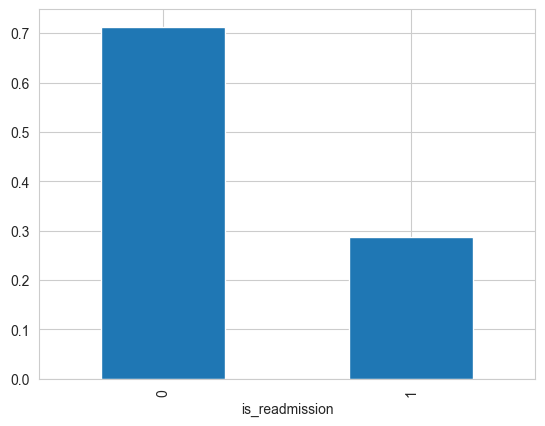

In [31]:
# Check for class imbalance
train_df_cleaned['is_readmission'].value_counts(normalize=True).plot(kind='bar')

#### Class Imblance
There is a significant class imbalance between patients who are readmitted within 30 days of an index visit and those who are not. This imbalance can severely impact the predictive performance of machine learning models, especially if not addressed properly.

For example, a model evaluated using a simple metric like accuracy may appear to perform well by predominantly predicting the majority class. However, it may fail to correctly identify patients at high risk of readmission — the minority class — which carries far greater clinical and financial consequences. Misclassifying a high-risk patient could result in an unplanned readmission, which on average costs the healthcare system approximately $15,000. In contrast, misclassifying a low-risk patient as high-risk may only result in unnecessary follow-up, consuming clinician time but with far less financial impact.

Therefore, it's essential to apply techniques such as resampling, cost-sensitive learning, or appropriate evaluation metrics (e.g., precision, recall, or cost-based analysis) to ensure the model remains effective and clinically useful.

To effectively evaluate my models for this task, I will use metrics such as precision, recall, F1-score, and the confusion matrix, which provide deeper insight into the model’s performance—particularly in the presence of class imbalance.

### Identify Multicolinearited Features

Some models may perform poorly when input features are highly correlated, as this multicollinearity can reduce predictive power and model stability. Addressing this by combining correlated variables or removing redundant ones can help reduce dimensionality and simplify the model, potentially improving both performance and interpretability.

In [36]:
# Variables that are linearly correlated with each other may be communicating the same information. So, I can just identify them in advance and remove them from the analysis or I can combine them into one variable all together.
from statsmodels.stats.outliers_influence import variance_inflation_factor
# VIF is a statistical method used to detect and quantify multicollinearity in regression models. It helps identify how much the variance of a regression coefficient is inflated due to the correlation between predictor variables.

features = train_df_cleaned.select_dtypes(include='float').drop(columns=['subject_id','hadm_id','readmit_stay_id'])
X = features.values

# VIF DataFrame
vif_df = pd.DataFrame()
# calculating VIF for each feature
vif_df['feature'] = features.columns
vif_df.set_index('feature', inplace=True)
vif_df["VIF"] = [round(variance_inflation_factor(X, i),1)
                          for i,value in enumerate(features)]



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


<Axes: ylabel='feature'>

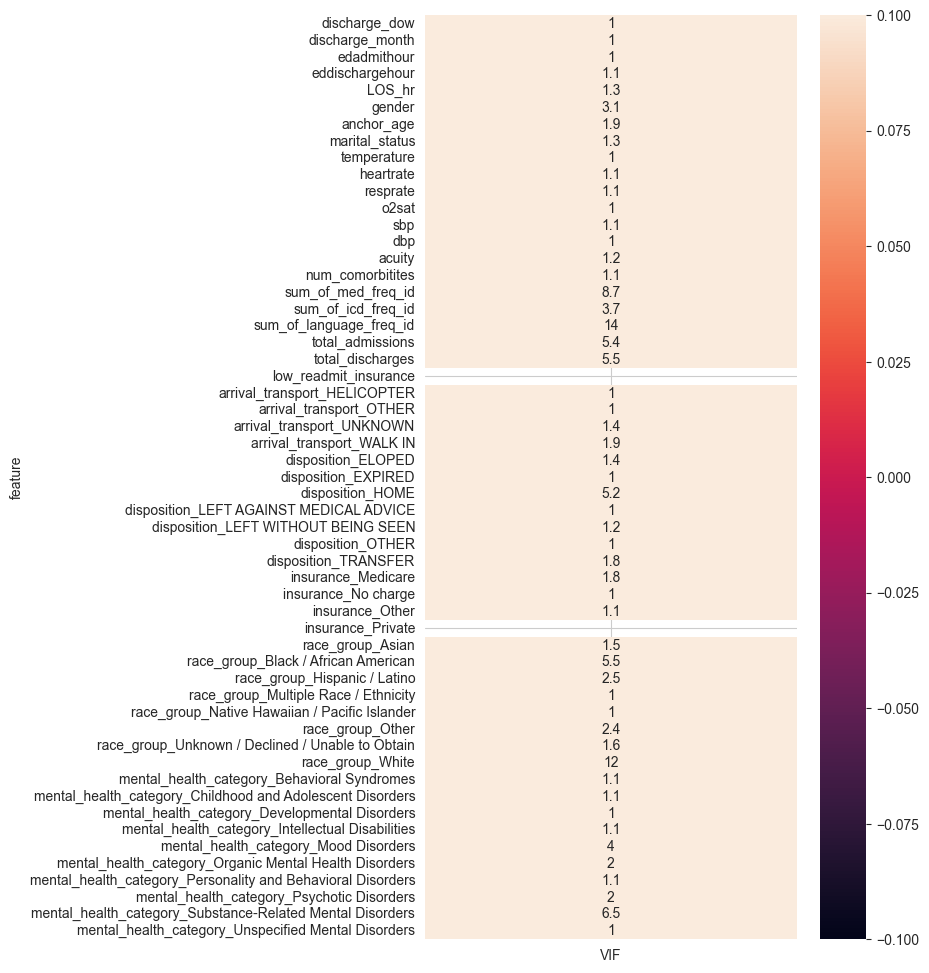

In [37]:
# Plot Heat Map
fig,ax = plt.subplots(figsize=(6,12))
sns.heatmap(vif_df,annot=True)

It seems that most variables have a low VIF indicating there isn't much multicolinearity. To get a better look I will use a correlation matrix

<Axes: >

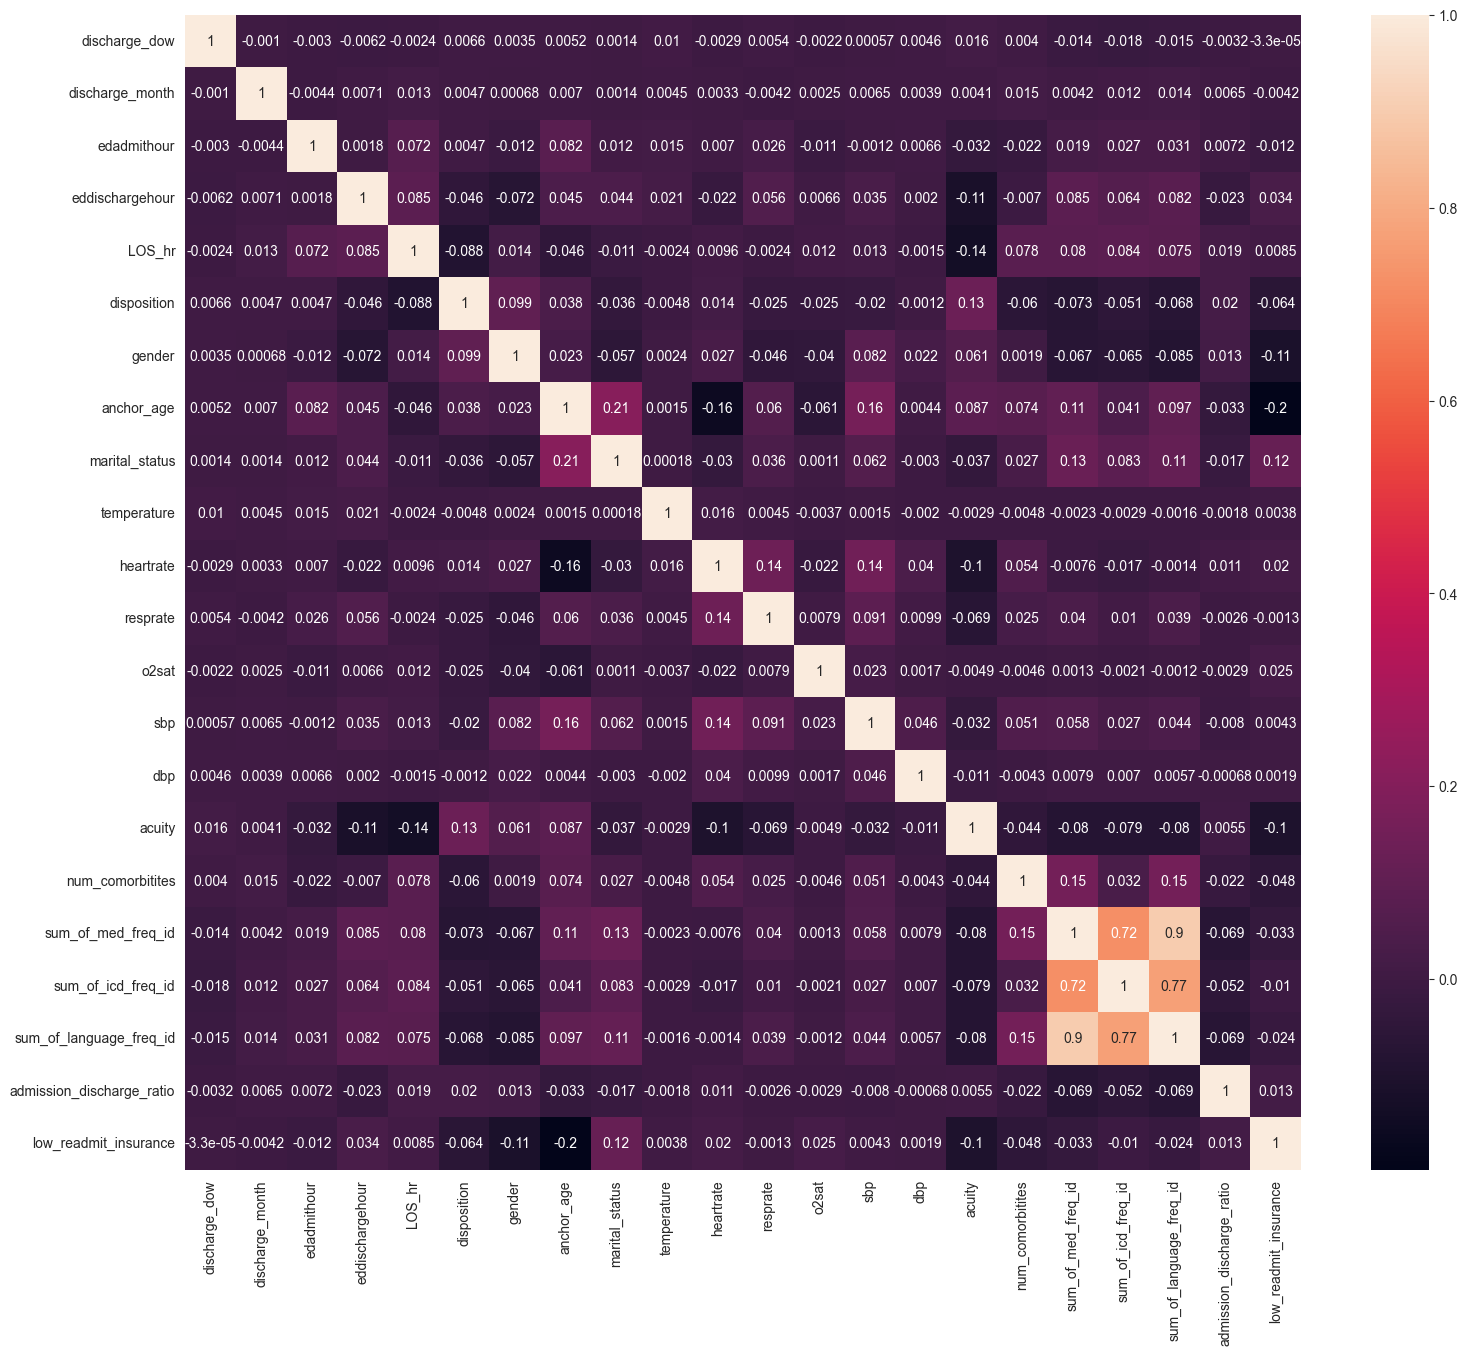

In [51]:
# Use a correlation matrix to identify which variables are correlated with one another
train_numeric_corr = train_df_cleaned.select_dtypes(include='number').drop(columns=['subject_id','hadm_id','readmit_stay_id'])
train_numeric_corr = train_numeric_corr.iloc[:,:22].corr()
# Plot heatmap
plt.figure(figsize=(18,15))
sns.heatmap(train_numeric_corr,annot=True)

There are some clearly correlated variables that I could consider combining or removing:

Total admissions and total discharges show a strong correlation. I could create a new feature representing the ratio of admissions to discharges to capture this relationship more effectively.

Other variables, such as language, and med freq ids, are also highly correlated but represent distinct concepts. I will keep them as they are for now since tree-based models are generally robust to multicollinearity. If necessary, I can revisit and drop one of them later. 

### Variables Most Correlated with Readmission within 30 days

In [434]:
mask = train_df_cleaned.drop(columns=['subject_id','hadm_id','readmit_stay_id']).corr()['is_readmission'].abs() > 0.1
mask[mask].index.tolist()

['disposition',
 'gender',
 'anchor_age',
 'acuity',
 'race_group_Black / African American',
 'race_group_White',
 'mental_health_category_Substance-Related Mental Disorders',
 'is_readmission']

### Handling Outliers

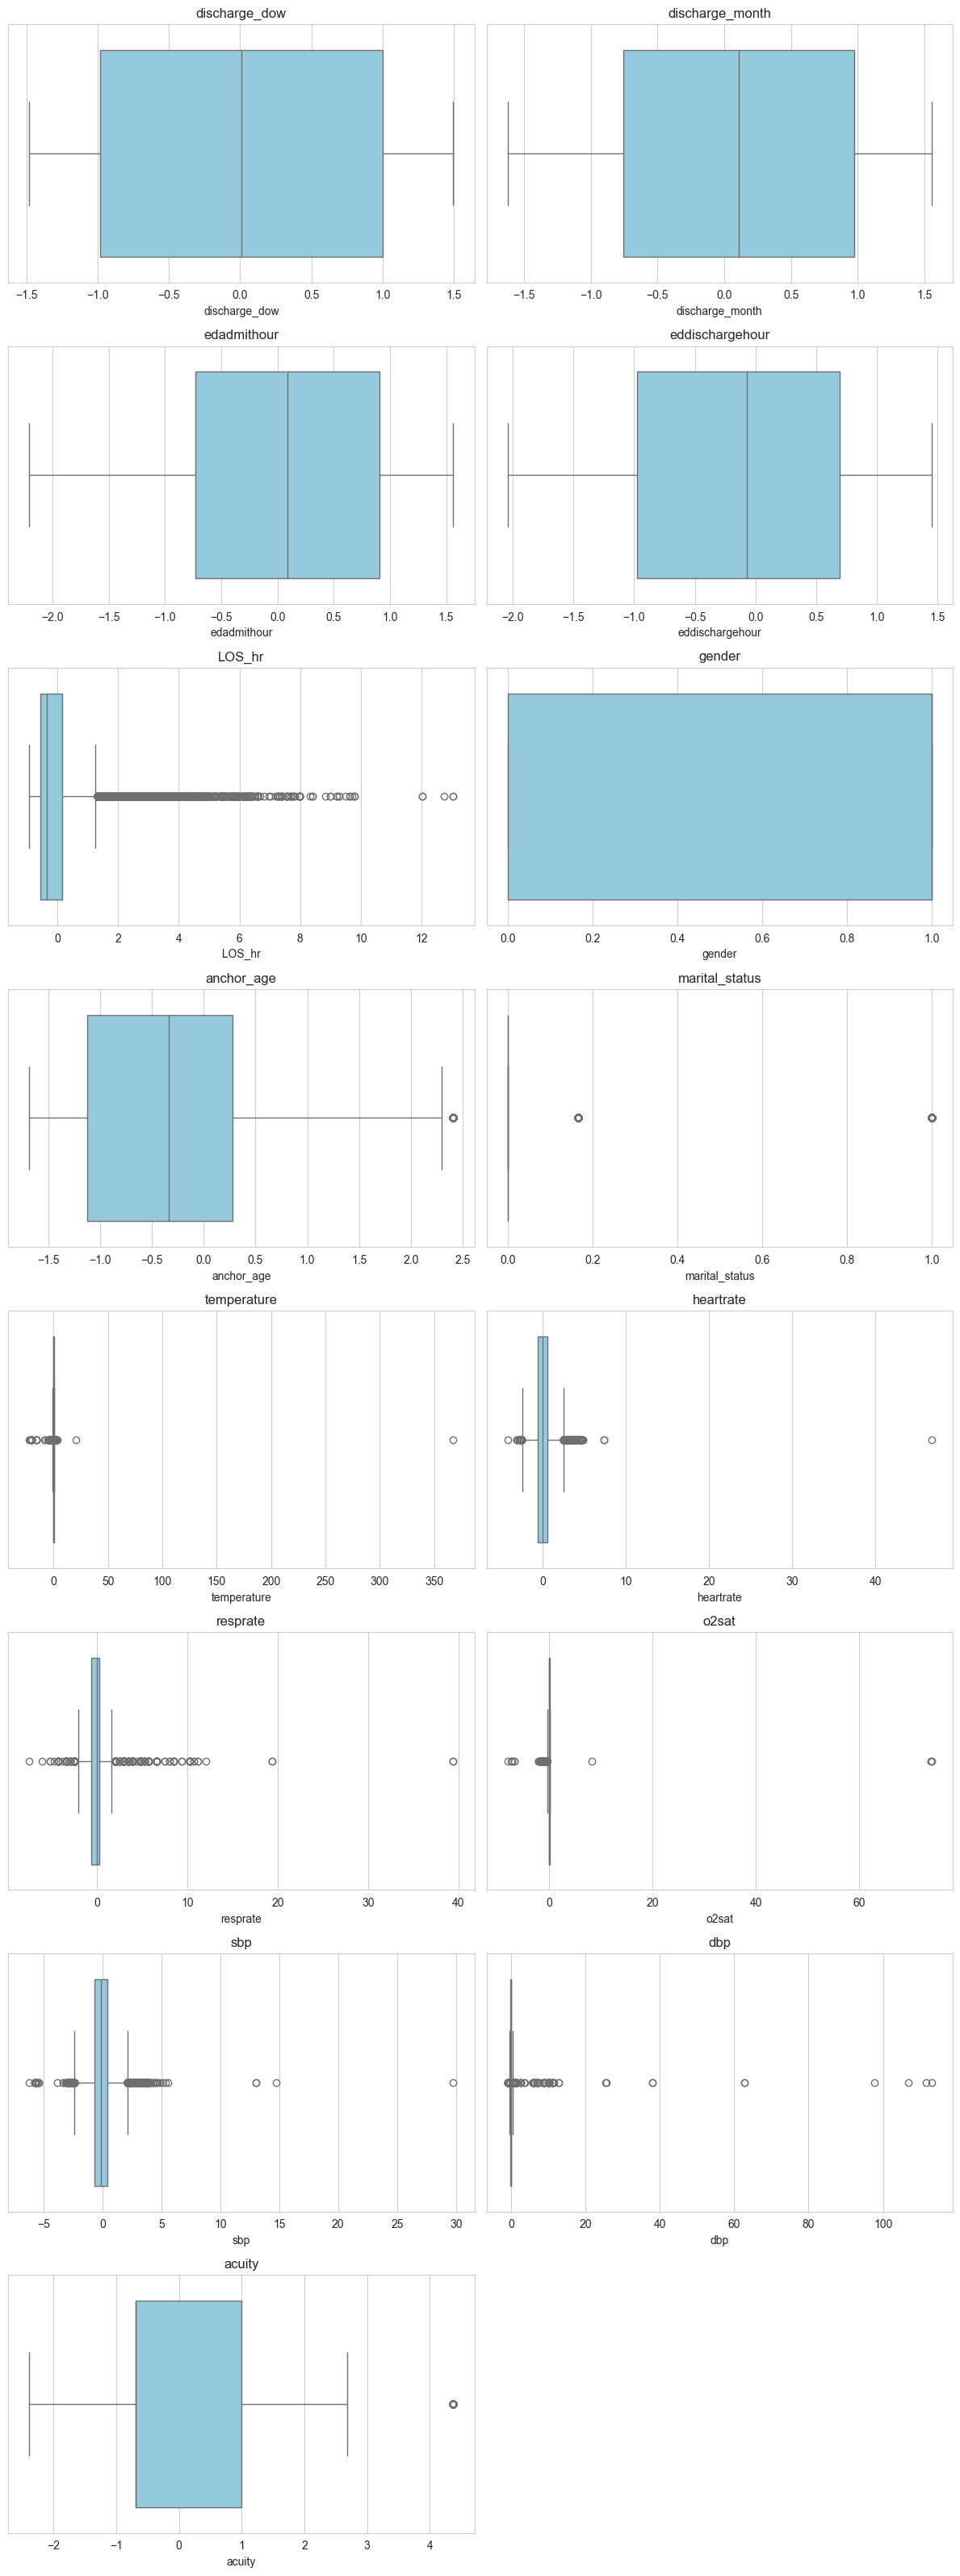

In [40]:
import math
# plot boxplots to identify which columns have outliers
# Select only numeric columns
numeric_columns = train_df_cleaned.select_dtypes(include='number').drop(columns=['subject_id','hadm_id','readmit_stay_id']).iloc[:,:15].columns

# Set up for 2 plots per row
cols = 2
rows = math.ceil(len(numeric_columns) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows))
axes = axes.flatten()

for i, column in enumerate(numeric_columns):
    sns.boxplot(data=train_df_cleaned, x=column, ax=axes[i], color='skyblue')
    axes[i].set_title(f'{column}', fontsize=12)
    axes[i].set_xlabel(column)

# Turn off any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

There are quite a few columns with outliers that I will have to deal with. While tree based models can handle outliers, I will simply impute them for my base models which are more simple and sensitive to outliers.

In [30]:
class OutlierImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.cols_ = None
        self.skip_columns = [
            'subject_id', 'stay_id', 'hadm_id', 'readmit_stay_id',
            'marital_status', 'gender',
            'sum_of_med_freq_id', 'sum_of_icd_freq_id', 'sum_of_language_freq_id',
            'low_readmit_insurance', 'admission_discharge_ratio'
        ]

    def fit(self, X, y=None):
        # Identify numeric columns to process
        numeric_cols = X.select_dtypes(include='number').columns
        self.cols_ = [col for col in numeric_cols 
                      if col not in self.skip_columns 
                      and col in X.columns][:14]
        return self

    def transform(self, X):
        df = X.copy()
        
        for col in self.cols_:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            LB = Q1 - 1.5 * IQR
            UB = Q3 + 1.5 * IQR

            outliers = (df[col] < LB) | (df[col] > UB)
            num_outliers = outliers.sum()
            median_val = df[col].median()
            df.loc[outliers, col] = median_val

            print(f"{col}: {num_outliers} outlier(s) imputed.")
        
        return df

# Transform Additional Variables

In [32]:
def ConvertLOSHr(x,mean):
    """
    Convert LOS to a binary variable of 
    :return: Binary variables
    """
    if x > mean:
        return 1
    else:
        return 0
    
def SystolicAndDystolicBPConverter(SB, DB):
    """
    Classifies blood pressure based on systolic and diastolic values.

    :param SB: Systolic Blood Pressure (int or float)
    :param DB: Diastolic Blood Pressure (int or float)
    :return: String category (e.g., 'Normal', 'Elevated', 'Stage 1 Hypertension', etc.)
    """
    if SB < 120 and DB < 80:
        return "Normal"
    elif 120 <= SB <= 129 and DB < 80:
        return "Elevated"
    elif (130 <= SB <= 139) or (80 <= DB <= 89):
        return "Stage 1 Hypertension"
    elif (140 <= SB <= 180) or (90 <= DB <= 120):
        return "Stage 2 Hypertension"
    elif SB > 180 or DB > 120:
        return "Hypertensive Crisis"
    else:
        return "Uncategorized"

def O2SatConverter(X):
    """
    :param X: o2sat level
    :return: binary variable
    """
    
    if X < 95:
        return 1
    else:
        return 0

### Update the Preprocessing Pipeline

In [96]:
# Add a transformer to modify total admissions and total discharges to one variable
class GetTotalAdmissionsAndDischarges(BaseEstimator, TransformerMixin):
    """
    Calculates total admissions and discharges per admission day and discharge day, respectively
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self  

    def transform(self, X):
        X_copy = X.copy().reset_index()
        
        # calculate the total admissions and total discharges 
        total_admissions = X_copy.groupby(by='edadmitdate')['stay_id'].count().reset_index().rename(columns={'stay_id':'total_admissions'})
        total_discharges = X_copy.groupby(by='eddischargedate')['stay_id'].count().reset_index().rename(columns={'stay_id':'total_discharges'})
        
        # merge these with original dataframe
        X_copy = X_copy.merge(total_admissions,how='left',on=['edadmitdate'])
        X_copy = X_copy.merge(total_discharges,how='left',on=['eddischargedate'])
        X_copy.drop(['edadmitdate','eddischargedate'],axis=1,inplace=True)
        
        # Create a ratio variable
        X_copy['admission_discharge_ratio'] = np.divide(X_copy['total_admissions'] , X_copy['total_discharges'] + 1e-5)
        X_copy.drop(['total_admissions','total_discharges'],axis=1,inplace=True)
        
        X_copy.set_index('stay_id', inplace=True)
        return X_copy

# Build Preprocessing Pipeline for later preprocessing of new data
X_train_preprocessing_Pipeline = Pipeline(
    [
        ('ConvertVitalSigns',ConvertVitalSignsToFloats()), # Converts vital signs to floats
        ('CelsiusToFahrenheit',CelsiusToFahrenheit()), # Standardizes temperature, converting it to Fahrenheit
        ('GetMedicationFrequencies',GetMedicationFrequencies()),# Converts medications into frequencies
        ('GetDiagnosesFrequencies',GetDiagnosesFrequencies()), # Converts Diagnosis to frequencies
        ('GetLanguageFrequencies',GetLanguageFrequencies()), # Converts languages to frequencies
        ('GetTotalAdmissionsAndDischarges',GetTotalAdmissionsAndDischarges()), # Calcaultes the total number of admissions and discharges for a given day
        ('Scaler', StandardScalar_Custom()), # Scales data
        ('MapGender',GenderMapper()), # Maps gender to 1 or 0, 1: male, 0: female
        ('MaritalStatusMapper',MaritalStatusMapper()), # Maps maritalstats to 1 or 0, 1: ismarried, 0: not married
        ('GetDisposition',GetDisposition()), # Maps disposition to 1 or 0. 1: LWBS, 0: Got treatment
        ('MapInsurance',InsuranceMapper()),# Maps insurance to 1 or 0. 1: low readmission, 0: high readmission
        ('OnehotEncoder',CreateDummies()),
        ('SimpleImputer', NumericImputer(strategy='median')),  # Fill the nulls with the median value for applicable features
    ]
)

# Build X Preprocessing Pipeline to impute outliers
X_train_preprocessing_pipeline_no_out = Pipeline(
    [
        ('ConvertVitalSigns',ConvertVitalSignsToFloats()), # Converts vital signs to floats
        ('CelsiusToFahrenheit',CelsiusToFahrenheit()), # Standardizes temperature, converting it to Fahrenheit
        ('GetMedicationFrequencies',GetMedicationFrequencies()),# Converts medications into frequencies
        ('GetDiagnosesFrequencies',GetDiagnosesFrequencies()), # Converts Diagnosis to frequencies
        ('GetLanguageFrequencies',GetLanguageFrequencies()), # Converts languages to frequencies
        ('GetTotalAdmissionsAndDischarges',GetTotalAdmissionsAndDischarges()), # Calcaultes the total number of admissions and discharges for a given day
        ('Scaler', StandardScalar_Custom()), # Scales data
        ('MapGender',GenderMapper()), # Maps gender to 1 or 0, 1: male, 0: female
        ('MaritalStatusMapper',MaritalStatusMapper()), # Maps maritalstats to 1 or 0, 1: ismarried, 0: not married
        ('GetDisposition',GetDisposition()), # Maps disposition to 1 or 0. 1: LWBS, 0: Got treatment
        ('MapInsurance',InsuranceMapper()),# Maps insurance to 1 or 0. 1: low readmission, 0: high readmission
        ('OnehotEncoder',CreateDummies()),
        ('SimpleImputer', NumericImputer(strategy='median')),  # Fill the nulls with the median value for applicable features
        ('OutlierImputer',OutlierImputer())
    ]
)

train_df_cleaned = X_train_preprocessing_Pipeline.fit_transform(train_df.drop(['is_readmission'],axis=1))
train_df_cleaned = train_df_cleaned.merge(train_df[['is_readmission']],left_index=True,right_index=True,how='left')
train_df_cleaned.drop_duplicates(inplace=True)
train_df_cleaned['bp_category'] = train_df_cleaned.apply(lambda row: SystolicAndDystolicBPConverter(row['sbp'], row['dbp']),axis=1)
train_df_cleaned['AboveAvgLOS'] = train_df_cleaned['LOS_hr'].apply(lambda x: ConvertLOSHr(x,train_df_cleaned['LOS_hr'].mean()))
train_df_cleaned['nonNormalo2sat'] = train_df_cleaned['o2sat'].apply(lambda x: O2SatConverter(x))
train_df_cleaned = pd.get_dummies(train_df_cleaned,columns=['bp_category'])


train_df_cleaned_no_out = X_train_preprocessing_pipeline_no_out.fit_transform(train_df.drop(['is_readmission'],axis=1))
train_df_cleaned_no_out = train_df_cleaned_no_out.merge(train_df[['is_readmission']],left_index=True,right_index=True,how='left')
train_df_cleaned_no_out.drop_duplicates(inplace=True)

train_df_cleaned_no_out['bp_category'] = train_df_cleaned_no_out.apply(lambda row: SystolicAndDystolicBPConverter(row['sbp'], row['dbp']),axis=1)
train_df_cleaned_no_out['AboveAvgLOS'] = train_df_cleaned_no_out['LOS_hr'].apply(lambda x: ConvertLOSHr(x,train_df_cleaned_no_out['LOS_hr'].mean()))
train_df_cleaned_no_out['nonNormalo2sat'] = train_df_cleaned_no_out['o2sat'].apply(lambda x: O2SatConverter(x))
train_df_cleaned_no_out = pd.get_dummies(train_df_cleaned_no_out,columns=['bp_category'])

discharge_dow: 0 outlier(s) imputed.
discharge_month: 0 outlier(s) imputed.
edadmithour: 0 outlier(s) imputed.
eddischargehour: 0 outlier(s) imputed.
LOS_hr: 12477 outlier(s) imputed.
disposition: 6753 outlier(s) imputed.
anchor_age: 0 outlier(s) imputed.
temperature: 7215 outlier(s) imputed.
heartrate: 1517 outlier(s) imputed.
resprate: 9739 outlier(s) imputed.
o2sat: 2045 outlier(s) imputed.
sbp: 3978 outlier(s) imputed.
dbp: 3534 outlier(s) imputed.
acuity: 309 outlier(s) imputed.


### Preprocess the Train and Test Set

In [35]:
# Use the X Train preprocessing Pipeline to transform the test data
test_df.set_index('stay_id',inplace=True)
test_df_cleaned = X_train_preprocessing_Pipeline.transform(test_df.drop(['is_readmission'], axis=1))
test_df_cleaned = test_df_cleaned.merge(test_df[['is_readmission']], left_index=True, right_index=True, how='left')
test_df_cleaned.drop_duplicates(inplace=True)

In [36]:
# Get the shapes of the train and test dfs
print('Train Shape:',train_df_cleaned.shape)
print('Test Shape:',test_df_cleaned.shape)

Train Shape: (51106, 56)
Test Shape: (30349, 52)


### Create Train, Validation, Test Splits

In [307]:
# Create the X_train, y_train variables
X_train = train_df_cleaned.drop(['subject_id','hadm_id','readmit_stay_id','is_readmission'],axis=1)
y_train = train_df_cleaned['is_readmission']

# Create a validation set
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.20,random_state=42,stratify=y_train) # use stratify to ensure both sets have the same class distribution as the original set

# Create the X_train_removed_outliers, y_train_removed_outliers variables
X_train_no_out = train_df_cleaned_no_out.drop(['subject_id','hadm_id','readmit_stay_id','is_readmission'],axis=1)
y_train_no_out = train_df_cleaned_no_out['is_readmission']

# Create a validation set no outliers
X_train_no_out,X_val_no_out,y_train_no_out,y_val_no_out = train_test_split(X_train_no_out,y_train_no_out,test_size=0.20,random_state=42)

# Create the X_test, y_test variables
X_test = test_df_cleaned.drop(['subject_id','hadm_id','readmit_stay_id','is_readmission'],axis=1)
y_test = test_df_cleaned['is_readmission']



print('X_train Shape:',X_train.shape)
print('y_train Shape:',y_train.shape)
print('X_train_no_out Shape:',X_train_no_out.shape)
print('y_train_no_out Shape:',y_train_no_out.shape)
print('X_val Shape:',X_val.shape)
print('y_val Shape:',y_val.shape)
print('X_test Shape:',X_test.shape)
print('y_test Shape:',y_test.shape)

X_train Shape: (40884, 52)
y_train Shape: (40884,)
X_train_no_out Shape: (40884, 51)
y_train_no_out Shape: (40884,)
X_val Shape: (10222, 52)
y_val Shape: (10222,)
X_test Shape: (30349, 48)
y_test Shape: (30349,)


### Model Building

To start, I will use simpler base models and then experiment with more complex tree-based models, which tend to be more robust but less interpretable.

In [435]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

#### Naive Bayes Model

In [39]:
X_train.columns

Index(['discharge_dow', 'discharge_month', 'edadmithour', 'eddischargehour',
       'LOS_hr', 'disposition', 'gender', 'anchor_age', 'marital_status',
       'temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'acuity',
       'num_comorbitites', 'sum_of_med_freq_id', 'sum_of_icd_freq_id',
       'sum_of_language_freq_id', 'admission_discharge_ratio',
       'low_readmit_insurance', 'arrival_transport_HELICOPTER',
       'arrival_transport_OTHER', 'arrival_transport_UNKNOWN',
       'arrival_transport_WALK IN', 'insurance_Medicare',
       'insurance_No charge', 'insurance_Other', 'insurance_Private',
       'race_group_Asian', 'race_group_Black / African American',
       'race_group_Hispanic / Latino', 'race_group_Multiple Race / Ethnicity',
       'race_group_Native Hawaiian / Pacific Islander', 'race_group_Other',
       'race_group_Unknown / Declined / Unable to Obtain', 'race_group_White',
       'mental_health_category_Behavioral Syndromes',
       'mental_health_cate

In [439]:
# Use the most correlated cols with readmission
nb_cols = ['disposition',
 'gender',
 'anchor_age',
 'marital_status',
 'acuity',
 'sum_of_icd_freq_id',
 'low_readmit_insurance',
 'insurance_Other',
 'insurance_Private',
 'race_group_Asian',
 'race_group_Black / African American',
 'race_group_White',
 'mental_health_category_Mood Disorders',
 'mental_health_category_Organic Mental Health Disorders',
 'mental_health_category_Substance-Related Mental Disorders',
  'bp_category_Stage 2 Hypertension','nonNormalo2sat','AboveAvgLOS']
X_train_NB = X_train[nb_cols]
X_val_NB = X_val[nb_cols]

naive_bayes = BernoulliNB()
naive_bayes.fit(X_train_NB,y_train)

BernoulliNB()

In [440]:
nb_y_pred_train = naive_bayes.predict(X_train_NB)
nb_y_pred_val = naive_bayes.predict(X_val_NB)

print("Best Model F1 score on train set: ",f1_score(y_train,nb_y_pred_train,average='binary'))
print("Best Model F1 score on validation set: ",f1_score(y_val,nb_y_pred_val,average='binary'))

Best Model F1 score on train set:  0.44744617982271
Best Model F1 score on validation set:  0.45469893078221724


In [441]:
NB_classification_report = classification_report(y_val, nb_y_pred_val)
print(NB_classification_report)

              precision    recall  f1-score   support

         0.0       0.78      0.84      0.81      7291
         1.0       0.51      0.41      0.45      2931

    accuracy                           0.72     10222
   macro avg       0.64      0.63      0.63     10222
weighted avg       0.70      0.72      0.71     10222


- The model's precision indicates that when it predicts readmissions, its accurate about 51% or a bit more than half the time. 
- The recall for the positive class is 41%, indicating the model is only identifying about 41% of actual readmissions.
- This suggests the model struggles more to detect readmissions than to correctly predict non-readmissions.
- Despite these limitations, Naive Bayes — being a simple baseline model — performs reasonably well on this task so far. There is room for improvement, especially in increasing recall for the positive class, which is critical to minimizing missed readmission cases.



#### Logistic Regression

In [100]:
lr_param_grid = {
    'C': np.logspace(-3,3,5),
    'penalty': ['l1'],
    'solver': ['liblinear','saga'],
    'max_iter': [100,500,1000],
    'class_weight':['balanced', None]
}

# Use Grid SearchCV to find the best parameters
lr_rs = GridSearchCV(LogisticRegression(), param_grid=lr_param_grid, cv=3, n_jobs=-1,scoring='f1') # use f1 score for model evaluation due to data imbalance

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The ma

GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'class_weight': ['balanced', None],
                         'max_iter': [100, 500, 1000], 'penalty': ['l1'],
                         'solver': ['liblinear', 'saga']},
             scoring='f1')

In [101]:
lr_rs.best_params_

{'C': 1.0,
 'class_weight': 'balanced',
 'max_iter': 100,
 'penalty': 'l1',
 'solver': 'liblinear'}

In [102]:
# Check to verify if there is any overfitting or underfitting present in the data
y_pred_train = lr_rs.predict(X_train_no_out)
y_pred_val = lr_rs.predict(X_val_no_out)

# Use weighted f1 average due to the data being imbalanced
print("Best model F1 score on train set:", f1_score(y_train_no_out, y_pred_train, average='binary'))
print("Best model F1 score on validation set:", f1_score(y_val_no_out, y_pred_val, average='binary'))


Best model F1 score on train set: 0.521480077186093
Best model F1 score on validation set: 0.522067755432582


In [122]:
LR_random_search_y_pred_val = lr_rs.predict(X_val_no_out)
logisitc_regression_classification_report = classification_report(y_val_no_out, LR_random_search_y_pred_val)
print(logisitc_regression_classification_report)

              precision    recall  f1-score   support

         0.0       0.82      0.65      0.73      7258
         1.0       0.44      0.65      0.52      2964

    accuracy                           0.65     10222
   macro avg       0.63      0.65      0.63     10222
weighted avg       0.71      0.65      0.67     10222


Text(0.5, 1.0, 'Confusion Matrix: Validation Data(Balanced)')

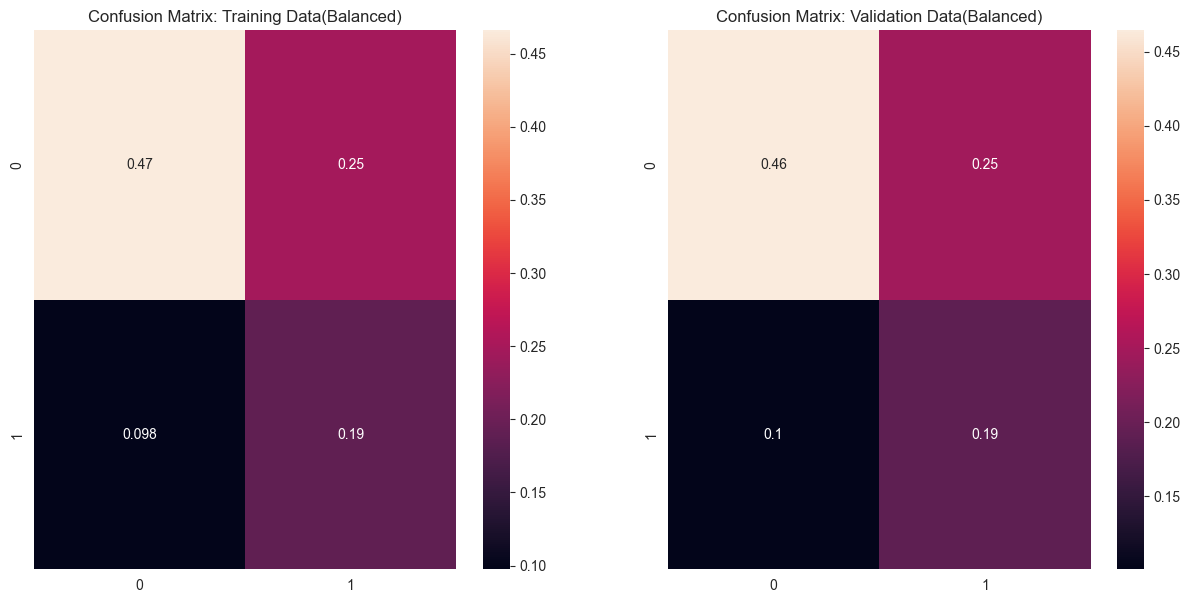

In [82]:
from sklearn.metrics import confusion_matrix

# Balanced Predicitions
train_conf_matrix_rnd = confusion_matrix(y_train_no_out, lr_rs.predict(X_train_no_out),normalize='all')
val_conf_matrix_rnd = confusion_matrix(y_val_no_out, lr_rs.predict(X_val_no_out),normalize='all')


# Create a confusion Matrix Heatmap of performance on the training and validation set
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2, figsize=(15,7))

# Heatmap: Training Data(Balanced)
sns.heatmap(train_conf_matrix_rnd,annot=True,ax=ax1)
ax1.set_title("Confusion Matrix: Training Data(Balanced)")

# Heatmap: Validation Data(Balanced)
sns.heatmap(val_conf_matrix_rnd,annot=True,ax=ax2)
ax2.set_title("Confusion Matrix: Validation Data(Balanced)")

#### Support Vector Machine

In [106]:
# SVM can take long to train on nonlinear data, so I will use only a sample of the training data and then use the optomized parameters and fit them to the full training data

# Sample only 10%
X_sample, _, y_sample, _ = train_test_split(
    X_train_no_out, y_train_no_out, 
    train_size=0.1, stratify=y_train_no_out, random_state=42
)


In [107]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV


svc_param_grid = {
    'C': np.logspace(-3,3,3), # 3 options
    'gamma': np.logspace(-3,3,3), # 3 options
    'class_weight':['balanced',{0: 1, 1: 3}] # 2 options
} # 3 x 3 x 2 = 18 X 3 = 54 combinations

# Use Random SearchCV to find the best parameters
# Randomly select 3 combinations of the 18 options and complete 2 rounds of training on sample data
svc_rand_search = RandomizedSearchCV(SVC(), param_distributions=svc_param_grid,n_iter=3, cv=2, n_jobs=-1,scoring='f1',random_state=42) # use f1 score for model evaluation due to data imbalance
svc_rand_search.fit(X_sample,y_sample)

RandomizedSearchCV(cv=2, estimator=SVC(), n_iter=3, n_jobs=-1,
                   param_distributions={'C': array([1.e-03, 1.e+00, 1.e+03]),
                                        'class_weight': ['balanced',
                                                         {0: 1, 1: 3}],
                                        'gamma': array([1.e-03, 1.e+00, 1.e+03])},
                   scoring='f1')

In [108]:
# Use the best parameters from the sample data and train and fit it to the full dataset
svc = SVC(C=1000,class_weight='balanced',gamma=0.001)
svc.fit(X_train_no_out,y_train_no_out)

SVC(C=1000, class_weight='balanced', gamma=0.001)

In [132]:
svc_rand_search.best_params_

{'gamma': 0.001, 'class_weight': 'balanced', 'C': 1000.0}

In [119]:
# Check to verify if there is any overfitting or underfitting present in the data
svc_y_pred_train = svc.predict(X_train_no_out)
svc_y_pred_val = svc.predict(X_val_no_out)

# Use binary average to get the models score on the positive class
print("Best model F1 score on train set:", f1_score(y_train_no_out, svc_y_pred_train, average='binary'))
print("Best model F1 score on validation set:", f1_score(y_val_no_out, svc_y_pred_val, average='binary'))

Best model F1 score on train set: 0.5648602002071108
Best model F1 score on validation set: 0.561038961038961


In [123]:
svc_classificatin_report = classification_report(y_val_no_out, svc_y_pred_val)

In [131]:
# Print the classification report for each of the base models
print('Classification Report for Naive Bayes\n')
print(NB_classification_report)
print('------------------------------------------------------------')
print('Classification Report for Logisitic Regression\n')
print(logisitc_regression_classification_report)
print('------------------------------------------------------------')
print('Classification Report for Support Vector Classifier\n')
print(svc_classificatin_report)


Classification Report for Naive Bayes

              precision    recall  f1-score   support

         0.0       0.78      0.84      0.81      7291
         1.0       0.51      0.41      0.45      2931

    accuracy                           0.72     10222
   macro avg       0.64      0.63      0.63     10222
weighted avg       0.70      0.72      0.71     10222

------------------------------------------------------------
Classification Report for Logisitic Regression

              precision    recall  f1-score   support

         0.0       0.82      0.65      0.73      7258
         1.0       0.44      0.65      0.52      2964

    accuracy                           0.65     10222
   macro avg       0.63      0.65      0.63     10222
weighted avg       0.71      0.65      0.67     10222

------------------------------------------------------------
Classification Report for Support Vector Classifier

              precision    recall  f1-score   support

         0.0       0.84      

The Support Vector Classifier (SVC) appeared to perform best overall in predicting readmission risk. Among all the models, it demonstrated the most balanced performance between identifying both positive (readmission) and negative (non-readmission) cases. While the precision for the positive class was relatively low at 47%, indicating a moderate rate of false positives, the recall was stronger at 69%, meaning the model was able to identify a majority of true readmissions. This suggests that the SVC is effective at catching most readmissions, though it may also misclassify some patients who are not at risk, leading to false alarms. Despite its imperfections, the SVC offered a favorable trade-off between sensitivity and precision compared to other models.

#### Decision Tree

In [259]:
from sklearn.tree import DecisionTreeClassifier
# Build a Decision Tree Model

dt_clf_params = {
    'splitter':['best','random'],
    'criterion':['gini','entropy'],
    'max_leaf_nodes': [8,10, 16, 20,30], # when a tree should reach its final decision point,smaller values less risk of overfitting
    'max_depth': [None, 8, 10, 20], # limits the depth of each decision tree, smaller values less risk of overfitting
    'class_weight':['balanced',{0:1,1:3},None], # addresses class imbalance
    'max_features':[np.logspace(-3,3,3)]
}

# Use Random SearchCV to find the best parameters
dt_rand_search = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), param_distributions=dt_clf_params, cv=10, n_iter=50, n_jobs=-1, random_state=42,scoring='f1') 
dt_rand_search.fit(X_train,y_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
150 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
86 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11

RandomizedSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'class_weight': ['balanced',
                                                         {0: 1, 1: 3}, None],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 8, 10, 20],
                                        'max_features': [array([1.e-03, 1.e+00, 1.e+03]),
                                                         'sqrt', 'log2'],
                                        'max_leaf_nodes': [8, 10, 16, 20, 30],
                                        'splitter': ['best', 'random']},
                   random_state=42, scoring='f1')

In [260]:
print(dt_rand_search.best_params_)
# these were the best for the postive class so far: {'splitter': 'best', 'max_leaf_nodes': 10, 'max_features': 'log2', 'max_depth': 20, 'criterion': 'entropy', 'class_weight': {0: 1, 1: 3}}

{'splitter': 'best', 'max_leaf_nodes': 30, 'max_features': 'log2', 'max_depth': 10, 'criterion': 'entropy', 'class_weight': {0: 1, 1: 3}}


In [265]:
dt_y_pred_train = dt_rand_search.predict(X_train)
dt_y_pred_val = dt_rand_search.predict(X_val)

# Use binary average to get the models score on the positive class
print("Best model F1 score on train set:", f1_score(y_train, dt_y_pred_train, average='binary'))
print("Best model F1 score on validation set:", f1_score(y_val, dt_y_pred_val, average='binary'))

Best model F1 score on train set: 0.5153091557669441
Best model F1 score on validation set: 0.5153300709078198


In [262]:
dt_classificatin_report = classification_report(y_train, dt_y_pred_val)
print(dt_classificatin_report)

              precision    recall  f1-score   support

         0.0       0.89      0.37      0.53     29162
         1.0       0.36      0.89      0.52     11722

    accuracy                           0.52     40884
   macro avg       0.63      0.63      0.52     40884
weighted avg       0.74      0.52      0.52     40884


### Voting Classifier
The Voting Classifier aggregates the predictions of multiple individual classifiers. The class that receives the majority of votes becomes the ensemble's final prediction. This approach is particularly useful when working with several weak learners or models, as combining them can produce a stronger and more robust overall model. It also allows for the use of interpretable models, which is especially important in clinical settings where understanding how a prediction is made can be as critical as the prediction itself—before moving on to more complex, less interpretable models like decision trees or ensemble methods.

In [281]:
from sklearn.ensemble import VotingClassifier
from sklearn.compose import ColumnTransformer

nb_cols = ['disposition','gender','anchor_age','marital_status','acuity','sum_of_icd_freq_id','low_readmit_insurance','insurance_Other','insurance_Private','race_group_Asian','race_group_Black / African American',
 'race_group_White','mental_health_category_Mood Disorders','mental_health_category_Organic Mental Health Disorders','mental_health_category_Substance-Related Mental Disorders','nonNormalo2sat','AboveAvgLOS']

# SVM can take long to train on nonlinear data, so I will use only a sample of the training data and then use the optomized parameters and fit them to the full training data

# Sample only 10%
X_sample, _, y_sample, _ = train_test_split(
    X_train_no_out, y_train_no_out, 
    train_size=0.1, stratify=y_train_no_out, random_state=42
)

# Pipeline
# I need the naive bayes model to only make predictions based off of the binary columns while the others use all the features
bayes_pipe = Pipeline([
    ('selector', ColumnTransformer([('binary', 'passthrough', nb_cols)], remainder='drop')),
    ('clf', BernoulliNB())
])

voting_clf = VotingClassifier(
    estimators=[
        ('bayes',bayes_pipe),
        ('lr',LogisticRegression(random_state=42)),
        ('dt',DecisionTreeClassifier(random_state=42))
    ], 
    voting = 'soft'
)
voting_clf_param_grid = {
    'weights': [[1, 2, 3],[1,3,2],None],
    'lr__C': np.logspace(-2,2,4),
    'lr__solver': ['liblinear','saga'],
    'lr__penalty': ['l1'],# 2 options
    'lr__class_weight':['balanced',None],
    'lr__max_iter': [100,500],# 3 options
    'dt__splitter':['best','random'],
    'dt__criterion':['gini','entropy'],
    'dt__max_leaf_nodes': [8,10, 16, 20,30], # when a tree should reach its final decision point,smaller values less risk of overfitting
    'dt__max_depth': [None, 8, 10, 20], # limits the depth of each decision tree, smaller values less risk of overfitting
    'dt__class_weight':['balanced',{0:1,1:3},None], # addresses class imbalance
    'dt__max_features':[np.logspace(-3,3,3)],
    'voting':['soft','hard']
}
voting_rnd_search = RandomizedSearchCV(voting_clf,random_state=42,param_distributions=voting_clf_param_grid,n_iter=30, cv=5, n_jobs=-1,scoring='f1',verbose=3)

In [282]:
voting_rnd_search.fit(X_train_no_out,y_train_no_out)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The ma

RandomizedSearchCV(cv=5,
                   estimator=VotingClassifier(estimators=[('bayes',
                                                           Pipeline(steps=[('selector',
                                                                            ColumnTransformer(transformers=[('binary',
                                                                                                             'passthrough',
                                                                                                             ['disposition',
                                                                                                              'gender',
                                                                                                              'anchor_age',
                                                                                                              'marital_status',
                                                                                                              'acuity',
                                                                                                              'sum_of_icd_freq_id',
                                                                                                              'low_readmit_insurance',
                                                                                                              'insurance_Other',
                                                                                                              'insurance_Private',
                                                                                                              'race_group_Asian',
                                                                                                              'race_group_Black '
                                                                                                              '/ '
                                                                                                              'African...
                                        'dt__max_leaf_nodes': [8, 10, 16, 20,
                                                               30],
                                        'dt__splitter': ['best', 'random'],
                                        'lr__C': array([1.00000000e-02, 2.15443469e-01, 4.64158883e+00, 1.00000000e+02]),
                                        'lr__class_weight': ['balanced', None],
                                        'lr__max_iter': [100, 500],
                                        'lr__penalty': ['l1'],
                                        'lr__solver': ['liblinear', 'saga'],
                                        'voting': ['soft', 'hard'],
                                        'weights': [[1, 2, 3], [1, 3, 2],
                                                    None]},
                   random_state=42, scoring='f1', verbose=3)

In [284]:
print(voting_rnd_search.best_estimator_)

VotingClassifier(estimators=[('bayes',
                              Pipeline(steps=[('selector',
                                               ColumnTransformer(transformers=[('binary',
                                                                                'passthrough',
                                                                                ['disposition',
                                                                                 'gender',
                                                                                 'anchor_age',
                                                                                 'marital_status',
                                                                                 'acuity',
                                                                                 'sum_of_icd_freq_id',
                                                                                 'low_readmit_insurance',
                                    

In [285]:
voting_clf_y_pred_train = voting_rnd_search.predict(X_train_no_out)
voting_clf_y_pred_val = voting_rnd_search.predict(X_val_no_out)

# Use binary average to get the models score on the positive class
print("Best model F1 score on train set:", f1_score(y_train_no_out, voting_clf_y_pred_train, average='binary'))
print("Best model F1 score on validation set:", f1_score(y_val_no_out, voting_clf_y_pred_val, average='binary'))

Best model F1 score on train set: 0.5259595358524248
Best model F1 score on validation set: 0.5304014167650531


In [286]:
voting_classificatin_report = classification_report(y_val_no_out, voting_clf_y_pred_val)
print(voting_classificatin_report)

              precision    recall  f1-score   support

         0.0       0.82      0.72      0.77      7258
         1.0       0.47      0.61      0.53      2964

    accuracy                           0.69     10222
   macro avg       0.64      0.66      0.65     10222
weighted avg       0.72      0.69      0.70     10222


### Feature Selection with Random Forest Model

Using the Random Forest Model or any other tree based model can be very effective for quickly seeing what features are important in your model. So, I will use a random forest here to do that.

In [237]:
from sklearn.ensemble import RandomForestClassifier


In [293]:

# The Random Forest Classifier is an ensemble model that trains on random samples of the training data provided (bootstrapping). It takes the classification from each of the models trained on a random sample of the data and selects the classification based on the majority of the models.The randomness of samples helps to reduce overfitting compared to if a single decision tree was used.


# Build a Random Forest Model

rnd_clf_params = {
    'n_estimators': [100, 200, 500,1000], # how many decision trees to train
    'max_leaf_nodes': [8,10, 16, 20], # when a tree should reach its final decision point,smaller values less risk of overfitting
    'max_depth': [None, 8, 10, 20], # limits the depth of each decision tree, smaller values less risk of overfitting
    'class_weight':['balanced','balanced_subsample',None], # addresses class imbalance
    'max_features':[np.logspace(-3,3,3),'sqrt', 'log2'],
    'criterion':['gini','entropy']
}

# Use Random SearchCV to find the best parameters
rnd_rand_search = RandomizedSearchCV(RandomForestClassifier(), param_distributions=rnd_clf_params, cv=5, n_iter=30, n_jobs=-1, random_state=42,scoring='f1') 
rnd_rand_search.fit(X_train,y_train)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
50 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=30,
                   n_jobs=-1,
                   param_distributions={'class_weight': ['balanced',
                                                         'balanced_subsample',
                                                         None],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 8, 10, 20],
                                        'max_features': [array([1.e-03, 1.e+00, 1.e+03]),
                                                         'sqrt', 'log2'],
                                        'max_leaf_nodes': [8, 10, 16, 20],
                                        'n_estimators': [100, 200, 500, 1000]},
                   random_state=42, scoring='f1')

In [294]:
# See how well the model fits the data by scoring it on the training data
y_pred_train = rnd_rand_search.predict(X_train)
y_pred_val = rnd_rand_search.predict(X_val)

# Use weighted average due to the data being imbalanced
print("F1 score: Best model score on train set:", f1_score(y_train, y_pred_train, average='binary'))
print("F1 score: Best model validation on train set:", f1_score(y_val, y_pred_val, average='binary'))


F1 score: Best model score on train set: 0.5608260501832535
F1 score: Best model validation on train set: 0.5557304335384176


In [295]:
y_pred = rnd_rand_search.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.84      0.71      0.77      7291
         1.0       0.48      0.66      0.56      2931

    accuracy                           0.70     10222
   macro avg       0.66      0.69      0.66     10222
weighted avg       0.74      0.70      0.71     10222


In [298]:
best_params = rnd_rand_search.best_params_

In [299]:
# Get Feature Importances
rnd_clf_optomized = RandomForestClassifier(n_estimators=best_params['n_estimators'], max_leaf_nodes=best_params['max_leaf_nodes'],n_jobs=-1,random_state=42,class_weight=best_params['class_weight'],max_depth=best_params['max_depth'],criterion=best_params['criterion'])
rnd_clf_optomized.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=20, max_leaf_nodes=20,
                       n_estimators=500, n_jobs=-1, random_state=42)

In [300]:
importances = rnd_clf_optomized.feature_importances_
feat_imporances = pd.DataFrame({'features': X_train.columns, 'importance': importances}).sort_values(by='importance',ascending=False)
feat_imporances['cumulative_importance'] = feat_imporances['importance'].cumsum()

In [301]:
feat_imporances

,features,importance,cumulative_importance
19,sum_of_language_freq_id,0.250300,0.250300
7,anchor_age,0.164925,0.415225
46,mental_health_category_Substance-Related Menta...,0.107842,0.523067
6,gender,0.082488,0.605555
18,sum_of_icd_freq_id,0.076298,0.681853
31,race_group_Black / African American,0.059690,0.741543
17,sum_of_med_freq_id,0.052773,0.794316
15,acuity,0.031771,0.826087
5,disposition,0.029143,0.855230
29,insurance_Private,0.021209,0.876439


In [302]:
# Selecting the features with less than 95% of importance means those features make 95% of importnace
important_features = feat_imporances[feat_imporances['cumulative_importance'] <= 0.95]['features'].tolist()


In [308]:
# Only retain the features that were most important in the models prediciton
X_train_rand_imp_feat = X_train[important_features].copy()
X_val_rand_imp_feat = X_val[important_features].copy()
X_test_rand_imp_feat = X_test[important_features].copy()
X_train_no_out_rand_imp_feat = X_train_no_out[important_features].copy()
X_val_no_out_rand_imp_feat = X_val_no_out[important_features].copy()

In [317]:
# Run the randomsearch again and train the new model with the most important features
rnd_clf_params = {
    'n_estimators': [100, 200, 500,1000], # how many decision trees to train
    'max_leaf_nodes': [8,10, 16, 20], # when a tree should reach its final decision point,smaller values less risk of overfitting
    'max_depth': [None, 8, 10, 20], # limits the depth of each decision tree, smaller values less risk of overfitting
    'class_weight':['balanced','balanced_subsample',None], # addresses class imbalance
    'max_features':[np.logspace(-3,3,3)],
    'criterion':['gini','entropy']
}

# Use Random SearchCV to find the best parameters
rf_rand_search_imp_feat = RandomizedSearchCV(RandomForestClassifier(), param_distributions=rnd_clf_params, cv=5, n_iter=30, n_jobs=-1, random_state=42,scoring='f1') 
rf_rand_search_imp_feat.fit(X_train_rand_imp_feat,y_train)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
50 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=30,
                   n_jobs=-1,
                   param_distributions={'class_weight': ['balanced',
                                                         'balanced_subsample',
                                                         None],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 8, 10, 20],
                                        'max_features': [array([1.e-03, 1.e+00, 1.e+03]),
                                                         'sqrt', 'log2'],
                                        'max_leaf_nodes': [8, 10, 16, 20],
                                        'n_estimators': [100, 200, 500, 1000]},
                   random_state=42, scoring='f1')

In [318]:
# See how well the model fits the data by scoring it on the training data
y_pred_train_imp_feat = rf_rand_search_imp_feat.predict(X_train_rand_imp_feat)
y_pred_val_imp_feat = rf_rand_search_imp_feat.predict(X_val_rand_imp_feat)

# Use weighted average due to the data being imbalanced
print("F1 score: Best model score on train set:", f1_score(y_train, y_pred_train, average='binary'))
print("F1 score: Best model validation on train set:", f1_score(y_val, y_pred_val, average='binary'))

F1 score: Best model score on train set: 0.5587735423675905
F1 score: Best model validation on train set: 0.5538287651879061


In [319]:
optomized_rdf_classification_report = classification_report(y_val, y_pred_val_imp_feat)
print(optomized_rdf_classification_report)

              precision    recall  f1-score   support

         0.0       0.84      0.71      0.77      7291
         1.0       0.48      0.66      0.55      2931

    accuracy                           0.69     10222
   macro avg       0.66      0.68      0.66     10222
weighted avg       0.73      0.69      0.71     10222


After applying RandomizedSearchCV with the scoring metric set to 'f1', the model better accounted for the class imbalance in the data. It identified that setting class_weight='balanced' led to more fair predictions across both the majority and minority classes. While this adjustment slightly reduced overall accuracy, it significantly improved the model’s ability to detect the minority class, which is especially important in a healthcare context where predicting readmissions is the priority.

In addition, leveraging feature importances to retain only the most predictive features further enhanced model performance. This combination of class balancing and feature selection boosted accuracy from the 50s to nearly 70%, marking a substantial improvement over the initial logistic regression baseline.

# More Advanced Models

#### Gradient Boositng Classifier

In [365]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils.class_weight import compute_sample_weight # since GradientBoostingClassifier does not inherently have a class_weight parameter, I'm using one from the sklearn library
sample_weights = compute_sample_weight(class_weight='balanced',y=y_train)

param_grid = {
    'n_estimators': [100, 200, 500,1000], # how many decision trees to train
    'max_leaf_nodes': [8,10,16,20], # when a tree should reach its final decision point,smaller values less risk of overfitting
    'max_depth': [None, 8, 10, 20], # limits the depth of each decision tree, smaller values less risk of overfitting
    'learning_rate': list(np.logspace(-3,3,3)),
    'subsample':[0.25,0.10,0.15],
    'max_features':[4,8,10,12],
    'criterion':['friedman_mse', 'squared_error'],
    'n_iter_no_change':[5]
}

gbrt_rnd_search = RandomizedSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid,
    scoring='f1_macro',
    n_iter=30,
    cv=10,
    n_jobs=-1,
    random_state=42 
)
gbrt_rnd_search.fit(X_train,y_train,sample_weight=sample_weights)

RandomizedSearchCV(cv=10, estimator=GradientBoostingClassifier(random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'criterion': ['friedman_mse',
                                                      'squared_error'],
                                        'learning_rate': [0.001, 1.0, 1000.0],
                                        'max_depth': [None, 8, 10, 20],
                                        'max_features': [4, 8, 10, 12, 'sqrt',
                                                         'log2'],
                                        'max_leaf_nodes': [8, 10, 16, 20],
                                        'n_estimators': [100, 200, 500, 1000],
                                        'n_iter_no_change': [5],
                                        'subsample': [0.25, 0.1, 0.15]},
                   random_state=42, scoring='f1_macro')

In [366]:
gbrt_rnd_search.best_params_

{'subsample': 0.1,
 'n_iter_no_change': 5,
 'n_estimators': 1000,
 'max_leaf_nodes': 16,
 'max_features': 12,
 'max_depth': 8,
 'learning_rate': 0.001,
 'criterion': 'friedman_mse'}

In [367]:
# See how well the model fits the data by scoring it on the training data
y_pred_train = gbrt_rnd_search.predict(X_train)
y_pred_val = gbrt_rnd_search.predict(X_val)

# Use weighted average due to the data being imbalanced
print("F1 score: Best model score on train set:", f1_score(y_train, y_pred_train, average='binary'))
print("F1 score: Best model validation on train set:", f1_score(y_val, y_pred_val, average='binary'))

F1 score: Best model score on train set: 0.5688645577076331
F1 score: Best model validation on train set: 0.5630299604296213


In [368]:
gbrt_classification_report = classification_report(y_val, y_pred_val)
print(gbrt_classification_report)

              precision    recall  f1-score   support

         0.0       0.85      0.70      0.77      7291
         1.0       0.48      0.68      0.56      2931

    accuracy                           0.70     10222
   macro avg       0.66      0.69      0.67     10222
weighted avg       0.74      0.70      0.71     10222


#### Histogram-Based Gradient Boosting Classifier

In [373]:
from sklearn.ensemble import HistGradientBoostingClassifier

hgb_param_grid = {
    'max_iter': [100, 200, 500,1000], # how many decision trees to train
    'max_leaf_nodes': [8,10,16,20,31], # when a tree should reach its final decision point,smaller values less risk of overfitting
    'max_depth': [None, 8, 10, 20], # limits the depth of each decision tree, smaller values less risk of overfitting
    'learning_rate': list(np.logspace(-3,3,3)),
    'max_features':[0.5,1.0],
    'max_bins':[100,150,200,255],
    'class_weight':['balanced',{0:1,1:2},{0:1,1:3}]
}

hgb_rnd_search = RandomizedSearchCV(
    HistGradientBoostingClassifier(random_state=42),
    hgb_param_grid,
    scoring='f1_macro',
    n_iter=30,
    cv=10,
    n_jobs=-1,
    random_state=42 
)
hgb_rnd_search.fit(X_train,y_train)


RandomizedSearchCV(cv=10,
                   estimator=HistGradientBoostingClassifier(random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'class_weight': ['balanced',
                                                         {0: 1, 1: 2},
                                                         {0: 1, 1: 3}],
                                        'learning_rate': [0.001, 1.0, 1000.0],
                                        'max_bins': [100, 150, 200, 255],
                                        'max_depth': [None, 8, 10, 20],
                                        'max_features': [0.5, 1.0],
                                        'max_iter': [100, 200, 500, 1000],
                                        'max_leaf_nodes': [8, 10, 16, 20, 31]},
                   random_state=42, scoring='f1_macro')

In [374]:
hgb_rnd_search.best_params_

{'max_leaf_nodes': 16,
 'max_iter': 500,
 'max_features': 0.5,
 'max_depth': 8,
 'max_bins': 255,
 'learning_rate': 1.0,
 'class_weight': {0: 1, 1: 2}}

In [375]:
# See how well the model fits the data by scoring it on the training data
y_pred_train = hgb_rnd_search.predict(X_train)
y_pred_val = hgb_rnd_search.predict(X_val)

# Use weighted average due to the data being imbalanced
print("F1 score: Best model score on train set:", f1_score(y_train, y_pred_train, average='binary'))
print("F1 score: Best model validation on train set:", f1_score(y_val, y_pred_val, average='binary'))

F1 score: Best model score on train set: 0.6335064435468359
F1 score: Best model validation on train set: 0.5916279069767442


In [376]:
hgb_classification_report = classification_report(y_val, y_pred_val)
print(hgb_classification_report)

              precision    recall  f1-score   support

         0.0       0.85      0.78      0.81      7291
         1.0       0.54      0.65      0.59      2931

    accuracy                           0.74     10222
   macro avg       0.69      0.72      0.70     10222
weighted avg       0.76      0.74      0.75     10222


# Stacking
Stacking is an ensemble method in which several models are combined much like the voting classifier but instead of using a simple function (such as hard voting) to aggregate the results from each model and thereby predict the target variable, the model is trained to perform this aggregation. What makes this benefical is that a team of helpers to improve predicition accuracy. The first layer contains the base models and then the final layer containts the meta model, which combines all of the predicitions of each model and generates one predicition. 

In [497]:
from sklearn.ensemble import StackingClassifier

bayes_pipe = Pipeline([
    ('selector', ColumnTransformer([('binary', 'passthrough', nb_cols)], remainder='drop')),
    ('clf', BernoulliNB())
])


base_learners = [
    ('rf',RandomForestClassifier( max_leaf_nodes= 20, n_estimators=500, max_depth= 20, class_weight= 'balanced')),
    ('hgb',HistGradientBoostingClassifier(max_leaf_nodes= 16,max_iter= 300,max_features=0.5,max_depth= 8,max_bins= 255,learning_rate= 1.0,class_weight= 'balanced'))
]

meta_learner = LogisticRegression()

stack_param = {
    'final_estimator__C': np.logspace(-2,2,4),
    'final_estimator__solver': ['liblinear','saga'],
    'final_estimator__penalty': ['l1','l2'],# 2 options
    'final_estimator__max_iter': [100,500],# 3 options
}

stacking_clf = StackingClassifier(estimators=base_learners,final_estimator=meta_learner,cv=10,verbose=1,n_jobs=-1,passthrough=True)

stacking_rnd_search = RandomizedSearchCV(stacking_clf,stack_param,n_iter=10,scoring='recall',n_jobs=-1,cv=2,random_state=42,verbose=2)

In [498]:
stacking_rnd_search.fit(X_train,y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The ma

RandomizedSearchCV(cv=2,
                   estimator=StackingClassifier(cv=10,
                                                estimators=[('rf',
                                                             RandomForestClassifier(class_weight='balanced',
                                                                                    max_depth=20,
                                                                                    max_leaf_nodes=20,
                                                                                    n_estimators=500)),
                                                            ('hgb',
                                                             HistGradientBoostingClassifier(class_weight='balanced',
                                                                                            learning_rate=1.0,
                                                                                            max_depth=8,
                                                                                            max_features=0.5,
                                                                                            max_iter=300,
                                                                                            max_leaf_nodes=16))],
                                                final_estimator=LogisticRegression(),
                                                n_jobs=-1, passthrough=True,
                                                verbose=1),
                   n_jobs=-1,
                   param_distributions={'final_estimator__C': array([1.00000000e-02, 2.15443469e-01, 4.64158883e+00, 1.00000000e+02]),
                                        'final_estimator__max_iter': [100, 500],
                                        'final_estimator__penalty': ['l1',
                                                                     'l2'],
                                        'final_estimator__solver': ['liblinear',
                                                                    'saga']},
                   random_state=42, scoring='recall', verbose=2)

In [501]:
# See how well the model fits the data by scoring it on the training data
y_pred_train = stacking_rnd_search.predict(X_train)
y_pred_val = stacking_rnd_search.predict(X_val)

# Use weighted average due to the data being imbalanced
print("F1 score: Best model score on train set:", f1_score(y_train, y_pred_train, average='binary'))
print("F1 score: Best model validation on train set:", f1_score(y_val, y_pred_val, average='binary'))

F1 score: Best model score on train set: 0.5950707710581016
F1 score: Best model validation on train set: 0.5590361445783133


In [502]:
stcking_rnd_learnerclassification_report = classification_report(y_val, y_pred_val)
print(stcking_rnd_learnerclassification_report)

              precision    recall  f1-score   support

         0.0       0.81      0.91      0.86      7291
         1.0       0.68      0.47      0.56      2931

    accuracy                           0.79     10222
   macro avg       0.75      0.69      0.71     10222
weighted avg       0.77      0.79      0.77     10222


# Build Model Pipeline